In [1]:
import tensorflow as tf
import keras_tuner
import numpy as np


import pandas as pd
import openpyxl # Needed for reading excel
import pathlib

import decomposition
import models


2023-03-08 16:48:57.848368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
keras_tuner.__version__

'1.3.0'

In [3]:
tf.config.list_logical_devices()

2023-03-08 16:49:01.309598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 16:49:01.322451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 16:49:01.322673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-08 16:49:01.323913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [24]:

cwd = pathlib.Path.cwd()

code_directory = cwd.parents[1]

bas_directory = code_directory / "notebooks" / "Bas"
gonem_directory = code_directory / "notebooks" / "Gonem"
# data_file = bas_directory / "cadeautjevoorGonemenLiza.xlsx"
example_data_directory = gonem_directory / "SS_data"
data_file = gonem_directory / "MAIZE_FILTERED_2023-03-03_02-09-43.xlsx"
data_file



PosixPath('/code/notebooks/Gonem/MAIZE_FILTERED_2023-03-03_02-09-43.xlsx')

In [5]:
df = pd.read_excel(data_file, header=[0, 1], index_col=0).iloc[:-2]
# df = df.loc[:, pd.IndexSlice[:, 'Ukraine']]
df.describe()

AVG_TAVG                                                  \
PARTNER_Labels      Brazil      France     Germany     Hungary     Ukraine   
count           214.000000  214.000000  214.000000  214.000000  214.000000   
mean            238.152301  125.494113  104.143755  116.576205   96.484903   
std              24.100760   55.456797   65.178828   79.286625   90.200095   
min             146.692308   20.168095  -29.860742  -50.419892  -98.247057   
25%             227.991548   77.127932   48.280935   44.350331   16.710027   
50%             245.982781  121.548459  102.466712  122.246111   92.398763   
75%             254.746595  177.640994  163.845330  190.244695  183.040152   
max             276.134483  231.747995  229.864177  242.571429  239.800437   

               Corn Price Futures    MAX_TMAX                          \
PARTNER_Labels             Global      Brazil      France     Germany   
count                  214.000000  214.000000  214.000000  214.000000   
mean                   449.422897  345.918892  225.531663  218.804582   
std                    151.626084   24.273653   67.153277   81.278888   
min                    201.750000  282.000000  107.622222   36.388889   
25%                    356.500000  331.000000  163.656487  140.181174   
50%                    390.125000  345.000000  228.556851  226.650735   
75%                    562.312500  360.425000  284.822581  287.334967   
max                    818.250000  401.000000  362.382979  371.823529   

                            ... renewable_energy_consumption_perc_of_total  \
PARTNER_Labels     Hungary  ...                                     Brazil   
count           214.000000  ...                                 214.000000   
mean            238.560202  ...                                  45.976355   
std              85.984321  ...                                   1.906558   
min              43.666667  ...                                  41.710000   
25%             163.500000  ...                                  44.876250   
50%             243.400000  ...                                  46.697083   
75%             316.700000  ...                                  47.570000   
max             392.500000  ...                                  48.920000   

                                                                \
PARTNER_Labels      France     Germany     Hungary     Ukraine   
count           214.000000  214.000000  214.000000  214.000000   
mean             12.883762   13.639136   13.302453    4.538575   
std               2.273139    2.851412    2.688740    2.132976   
min               8.520000    7.280000    7.290000    1.270000   
25%              11.155000   11.109375   12.801875    2.810000   
50%              13.286667   13.971250   13.640000    3.498750   
75%              15.310000   16.448125   15.377917    7.082500   
max              15.530000   17.170000   17.180000    7.440000   

               unemployment_total                                      \
PARTNER_Labels             Brazil      France     Germany     Hungary   
count                  214.000000  214.000000  214.000000  214.000000   
mean                    10.125584    8.969860    5.587944    6.981075   
std                      2.288750    0.867082    2.216610    2.708968   
min                      6.760000    7.390000    3.140000    3.420000   
25%                      8.205833    8.086250    3.646250    4.070833   
50%                      9.536250    9.068750    5.011250    7.343333   
75%                     12.473750    9.789167    7.403125    9.545000   
max                     13.700000   10.350000   11.170000   11.170000   

                            
PARTNER_Labels     Ukraine  
count           214.000000  
mean              8.363902  
std               1.103329  
min               6.350000  
25%               7.477500  
50%               8.522083  
75%               9.293125  
max               9.830000  

[8 rows x 63 columns]

In [6]:
label_columns = ['price']
label_columns = df.columns[df.columns.get_level_values(0).isin(label_columns)].tolist()
label_columns

[('price', 'Brazil'),
 ('price', 'France'),
 ('price', 'Germany'),
 ('price', 'Global'),
 ('price', 'Hungary'),
 ('price', 'Ukraine')]

In [7]:
stl = decomposition.STLDecomposer(labels=label_columns, period=12)
log = decomposition.Logger(labels=label_columns)
std = decomposition.Standardizer()
mms = decomposition.MinMaxScaler()

preproc = decomposition.Processor().add(stl).add(log).add(std)

In [8]:
from windower import WindowGenerator

width = 24
label_width = 6
shift = 6

w = WindowGenerator(input_width=width, label_width=label_width, shift=shift, data=df, 
                    # train_begin=0, train_end=.9, val_begin=None, val_end=.96,
                    train_begin=0, train_end=.97, val_begin=None, val_end=None,
                    # train_begin=0, train_end=.5, val_begin=None, val_end=.8,
                    test_begin=None, test_end=1., connect=True, remove_labels=True, label_columns=label_columns)
w.preprocess(preproc)
w

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): [('price', 'Brazil'), ('price', 'France'), ('price', 'Germany'), ('price', 'Global'), ('price', 'Hungary'), ('price', 'Ukraine')]

In [9]:
w.train_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2021-11-01     1.152042       4.087749       0.822301    1.892490   
2021-12-01     1.147873      -0.569034      -0.264020    1.761404   
2022-01-01     1.139729      -0.155443      -0.079601    1.621999   
2022-02-01     1.126977       0.017135      -0.103347    1.474924   
2022-03-01     1.109234      -0.281005      -0.409841    1.320800   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2021-11-01       -2.381107       0.321732    1.801032      -0.824824   
2021-12-01        2.749452      -2.406993    1.925765      -0.147694   
2022-01-01       -1.227540       0.879453    2.051231       0.404508   
2022-02-01        2.955088      -1.669538    2.177740       0.218855   
2022-03-01        2.378568      -0.738195    2.305615       1.126411   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2021-11-01       -0.475178    2.441710  ...          -1.339159 -0.938878   
2021-12-01       -1.175928    2.566864  ...          -1.339159 -0.938878   
2022-01-01        0.008637    2.689858  ...          -1.339159 -0.938878   
2022-02-01        0.445674    2.810762  ...          -1.339159 -0.938878   
2022-03-01        0.767055    2.929666  ...          -1.339159 -0.938878   

                                   price                                \
              Hungary  Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2021-11-01  -1.122596  1.39341  3.211244  1.103208  0.984585  1.614126   
2021-12-01  -1.122596  1.39341  0.111976  1.183113  0.962737  1.882830   
2022-01-01  -1.122596  1.39341  0.949587  1.334444  1.553425  1.794491   
2022-02-01  -1.122596  1.39341  1.060388  1.271195  1.721903  2.165919   
2022-03-01  -1.122596  1.39341  0.155542  1.348502  2.046054  2.268144   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2021-11-01   2.353540  0.980424  
2021-12-01   0.948267  1.669260  
2022-01-01   1.946410  1.251746  
2022-02-01   1.881186  1.750171  
2022-03-01   1.755316  1.869880  

[5 rows x 81 columns]

In [10]:
# all(w.train_df == w.val_df)
w.val_df.head(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2005-01-01    -1.580179      -0.033289       0.168993   -1.931166   
2005-02-01    -1.505664      -0.103264       0.185598   -1.898259   
2005-03-01    -1.429504       0.201713      -0.019082   -1.865651   
2005-04-01    -1.352375       0.385311      -0.185514   -1.833160   
2005-05-01    -1.275052       0.381132      -0.171745   -1.800612   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2005-01-01        0.731859      -0.240543   -2.378319      -0.180142   
2005-02-01        0.780536      -0.264521   -2.347243       0.306460   
2005-03-01       -0.147951       0.238452   -2.316005       0.471407   
2005-04-01       -0.300116      -0.065400   -2.284661       0.164613   
2005-05-01       -0.030081       0.010476   -2.253189       0.176419   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2005-01-01        0.543452   -2.080851  ...          -0.148683  2.481470   
2005-02-01       -0.372704   -2.044557  ...          -0.153546  2.446966   
2005-03-01       -0.052199   -2.008348  ...          -0.158409  2.412463   
2005-04-01       -0.349635   -1.972104  ...          -0.163272  2.377959   
2005-05-01       -0.075181   -1.935701  ...          -0.168135  2.343456   

                                    price                                \
              Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                               
2005-01-01   0.040680 -1.042821 -0.521366 -1.785991 -1.989881 -1.937839   
2005-02-01   0.049942 -1.071167 -0.521366 -1.738325 -2.414601 -2.100740   
2005-03-01   0.059204 -1.099513 -0.485550 -1.749550 -2.049020 -1.980676   
2005-04-01   0.068465 -1.127859 -0.589783 -1.968201 -2.378616 -2.210023   
2005-05-01   0.077727 -1.156205 -0.440768 -1.762277 -2.119592 -1.939840   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2005-01-01  -1.078649  0.184703  
2005-02-01  -1.150978  0.012096  
2005-03-01  -1.209392  0.311921  
2005-04-01  -1.174462 -0.058310  
2005-05-01  -0.978474  0.470985  

[5 rows x 81 columns]

In [11]:
w.val_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2021-11-01     1.152042       4.087749       0.822301    1.892490   
2021-12-01     1.147873      -0.569034      -0.264020    1.761404   
2022-01-01     1.139729      -0.155443      -0.079601    1.621999   
2022-02-01     1.126977       0.017135      -0.103347    1.474924   
2022-03-01     1.109234      -0.281005      -0.409841    1.320800   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2021-11-01       -2.381107       0.321732    1.801032      -0.824824   
2021-12-01        2.749452      -2.406993    1.925765      -0.147694   
2022-01-01       -1.227540       0.879453    2.051231       0.404508   
2022-02-01        2.955088      -1.669538    2.177740       0.218855   
2022-03-01        2.378568      -0.738195    2.305615       1.126411   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2021-11-01       -0.475178    2.441710  ...          -1.339159 -0.938878   
2021-12-01       -1.175928    2.566864  ...          -1.339159 -0.938878   
2022-01-01        0.008637    2.689858  ...          -1.339159 -0.938878   
2022-02-01        0.445674    2.810762  ...          -1.339159 -0.938878   
2022-03-01        0.767055    2.929666  ...          -1.339159 -0.938878   

                                   price                                \
              Hungary  Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2021-11-01  -1.122596  1.39341  3.211244  1.103208  0.984585  1.614126   
2021-12-01  -1.122596  1.39341  0.111976  1.183113  0.962737  1.882830   
2022-01-01  -1.122596  1.39341  0.949587  1.334444  1.553425  1.794491   
2022-02-01  -1.122596  1.39341  1.060388  1.271195  1.721903  2.165919   
2022-03-01  -1.122596  1.39341  0.155542  1.348502  2.046054  2.268144   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2021-11-01   2.353540  0.980424  
2021-12-01   0.948267  1.669260  
2022-01-01   1.946410  1.251746  
2022-02-01   1.881186  1.750171  
2022-03-01   1.755316  1.869880  

[5 rows x 81 columns]

In [12]:
w.test_df.head(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2019-11-01    -1.356312       1.783123       0.613835   -1.477992   
2019-12-01    -1.260415       0.267536      -0.122423   -1.199474   
2020-01-01    -1.160154       0.058314      -0.045474   -0.919530   
2020-02-01    -1.056111       0.073070      -0.070002   -0.638764   
2020-03-01    -0.948788       0.297082      -0.232470   -0.358050   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2019-11-01        2.364478       0.566794    0.374042       0.125635   
2019-12-01       17.319034       1.091934    0.415039       3.843534   
2020-01-01        1.771234       0.677278    0.451964       0.162017   
2020-02-01        4.250008      -1.421001    0.484864       2.193019   
2020-03-01        2.486478      -1.029892    0.514118       1.337957   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2019-11-01       -0.593035   -0.972535  ...          -1.086280 -0.862370   
2019-12-01       -0.712398   -0.837209  ...          -1.125184 -0.835368   
2020-01-01       -0.645471   -0.701512  ...          -1.164089 -0.808365   
2020-02-01       -0.559492   -0.565529  ...          -1.178678 -0.819241   
2020-03-01       -0.407893   -0.429376  ...          -1.193267 -0.830117   

                                    price                                \
              Hungary   Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                               
2019-11-01  -1.099751  0.873988  1.984879 -0.297268  0.176812 -0.233763   
2019-12-01  -1.074127  0.972816 -0.497831  2.896538  1.063024  0.046399   
2020-01-01  -1.048502  1.071644 -0.560252  0.083916  0.223349 -0.162847   
2020-02-01  -1.054677  1.098458 -0.477709  0.103096  0.789385 -0.095393   
2020-03-01  -1.060851  1.125272 -0.429849  0.041517  0.663871  0.132499   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2019-11-01   0.109866 -0.888247  
2019-12-01  -0.321027 -0.834174  
2020-01-01   2.754658 -0.815125  
2020-02-01   0.244221 -0.724015  
2020-03-01   0.155470 -0.503040  

[5 rows x 81 columns]

In [13]:
w.test_df.tail(5)

price_trend price_seasonal price_residual price_trend  \
                 Brazil         Brazil         Brazil      France   
TIME_PERIOD                                                         
2022-06-01     0.941419      -0.475776       0.112838    2.588959   
2022-07-01     0.885367      -0.668505       0.135618    2.650066   
2022-08-01     0.829343      -1.141253       0.110965    2.715711   
2022-09-01     0.773468      -0.883928       0.175384    2.786118   
2022-10-01     0.717567      -0.057395      -0.269525    2.861351   

            price_seasonal price_residual price_trend price_seasonal  \
                    France         France     Germany        Germany   
TIME_PERIOD                                                            
2022-06-01       -0.313244      -0.602250    5.819521       9.959318   
2022-07-01        4.235776       0.846882    6.203896      -2.175068   
2022-08-01       -0.829444       0.113682    6.585235      -6.290689   
2022-09-01       10.252740       0.705032    6.962552     -19.853076   
2022-10-01        9.428552       1.413645    7.335331      -9.693487   

            price_residual price_trend  ... unemployment_total            \
                   Germany      Global  ...             France   Germany   
TIME_PERIOD                             ...                                
2022-06-01        0.842895    4.159954  ...          -1.339159 -0.938878   
2022-07-01       -0.417677    4.361691  ...          -1.339159 -0.938878   
2022-08-01       -0.638491    4.563520  ...          -1.339159 -0.938878   
2022-09-01       -1.983182    4.765273  ...          -1.339159 -0.938878   
2022-10-01       -0.582022    4.966920  ...          -1.339159 -0.938878   

                                   price                                \
              Hungary  Ukraine    Brazil    France   Germany    Global   
TIME_PERIOD                                                              
2022-06-01  -1.122596  1.39341  0.835662  1.654303  4.493844  3.611875   
2022-07-01  -1.122596  1.39341  0.639702  2.762692  2.962163  4.164267   
2022-08-01  -1.122596  1.39341 -0.134071  1.835296  2.455755  1.795943   
2022-09-01  -1.122596  1.39341  0.379337  3.547973 -0.900890  2.818962   
2022-10-01  -1.122596  1.39341  0.467988  3.609550  2.263762  3.389607   

                                 
              Hungary   Ukraine  
TIME_PERIOD                      
2022-06-01   1.441408  3.622691  
2022-07-01   1.253016  3.271409  
2022-08-01   1.583087  3.247852  
2022-09-01   1.176588  2.535439  
2022-10-01   1.269017  2.525034  

[5 rows x 81 columns]

In [14]:
label_std = decomposition.Standardizer(mean=std.mean[w.label_columns], std=std.std[w.label_columns])
label_log = decomposition.Logger(label_indices=range(len(w.label_columns)))
# label_mms = decomposition.MinMaxScaler(min=mms.min[w.label_columns], max=mms.max[w.label_columns])
postproc = decomposition.Processor().add(label_std).add(label_log)
w.add_label_postprocess(postproc)

In [15]:
for example_inputs, example_labels in w.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    output_features = example_labels.shape[-1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Inputs shape (batch, time, features): (32, 24, 75)
Labels shape (batch, time, features): (32, 6, 6)


In [16]:

@tf.function
def closs(x, y, a=-1):
    return (x - y)**2 + (tf.sign(x-y)+a)**6

In [17]:
def build_ARF(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    prediction_units = hp.Int("prediction_units", min_value=32, max_value=512, step=32)
    prediction_layers = hp.Int("prediction_layers", min_value=0, max_value=10)
    feature_units = hp.Int("feature_units", min_value=32, max_value=512, step=32)
    feature_layers = hp.Int("feature_layers", min_value=0, max_value=10)
    
    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    # l1 = 0.001
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    # l2 = 0.001
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    model = models.AutoregressiveFeedback(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers,
                                   prediction_units=prediction_units, prediction_layers=prediction_layers, feature_units=feature_units,
                                   feature_layers=feature_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)
    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape', closs]
        )

    return model

In [18]:
def build_SS(hp):
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=512, step=32)
    lstm_layers = hp.Int("lstm_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)
    

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    model = models.SingleShot(out_steps=label_width, number_of_features=output_features, lstm_units=lstm_units, lstm_layers=lstm_layers, dense_units=dense_units, dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [19]:
def build_ED(hp):
    encoder_units = hp.Int("encoder_units", min_value=32, max_value=512, step=32)
    encoder_layers = hp.Int("encoder_layers", min_value=0, max_value=10)
    decoder_units = hp.Int("decoder_units", min_value=32, max_value=512, step=32)
    decoder_layers = hp.Int("decoder_layers", min_value=0, max_value=10)
    dense_units = hp.Int("dense_units", min_value=32, max_value=512, step=32)
    dense_layers = hp.Int("dense_layers", min_value=0, max_value=10)

    heads = hp.Int("heads", min_value=1, max_value=16)
    dropout = hp.Float("dropout", min_value=0, max_value=1)
    key_dim = hp.Int('key_dim', min_value=16, max_value=128, step=16)
    
    l1 = hp.Float("l1", min_value=1e-7, max_value=1e-1, sampling="log")
    l2 = hp.Float("l2", min_value=1e-7, max_value=1e-1, sampling="log")
    kernel_regularizer = tf.keras.regularizers.L1L2(l1=l1, l2=l2)

    model = models.EncoderDecoder(out_steps=label_width, number_of_features=output_features, encoder_units=encoder_units, encoder_layers=encoder_layers,
                           decoder_units=decoder_units, decoder_layers=decoder_layers, dense_units=dense_units,
                           dense_layers=dense_layers, key_dim=key_dim, heads=heads, dropout=dropout, kernel_regularizer=kernel_regularizer)

    learning_rate = hp.Float("learning_rate", min_value=1e-7, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse', 
        metrics=['mae', 'mse', 'mape']
        )

    return model

In [20]:

tuner_arf = keras_tuner.Hyperband(
    hypermodel=build_ARF,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ARF",
)

INFO:tensorflow:Reloading Tuner from /code/notebooks/Gonem/hp/ARF/tuner0.json


In [21]:
tuner_ss = keras_tuner.Hyperband(
    hypermodel=build_SS,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="SS",
)

INFO:tensorflow:Reloading Tuner from /code/notebooks/Gonem/hp/SS/tuner0.json


In [22]:
tuner_ed = keras_tuner.Hyperband(
    hypermodel=build_ED,
    objective="val_mse",
    max_epochs=200,
    factor=3,
    hyperband_iterations=1,
    executions_per_trial=3,
    seed=2023,
    max_retries_per_trial=10,
    max_consecutive_failed_trials=10,
    overwrite=False,
    directory=gonem_directory/'hp',
    project_name="ED",
)

INFO:tensorflow:Reloading Tuner from /code/notebooks/Gonem/hp/ED/tuner0.json


In [31]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
tuner_arf.search(w.train, validation_data=w.val, callbacks=[early_stopping_callback], verbose=2)


Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
448               |224               |lstm_units
9                 |5                 |lstm_layers
160               |288               |prediction_units
0                 |1                 |prediction_layers
512               |64                |feature_units
4                 |3                 |feature_layers
1                 |12                |heads
0.77996           |0.28575           |dropout
64                |96                |key_dim
0.035807          |0.009259          |l1
0.024995          |2.9063e-05        |l2
6.0507e-05        |2.4318e-07        |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


KeyboardInterrupt: 

In [26]:
tuner_ss.search(w.train, validation_data=w.val, callbacks=[early_stopping_callback], verbose=2)

Trial 257 Complete [00h 01m 04s]
val_mse: 0.8913493951161703

Best val_mse So Far: 0.024450091645121574
Total elapsed time: 00h 32m 09s

Search: Running Trial #258

Value             |Best Value So Far |Hyperparameter
320               |480               |lstm_units
4                 |0                 |lstm_layers
32                |224               |dense_units
6                 |0                 |dense_layers
4                 |12                |heads
0.42466           |0.21587           |dropout
32                |96                |key_dim
0.017417          |3.9392e-06        |l1
1.2278e-05        |4.0345e-05        |l2
0.0003252         |0.005069          |learning_rate
8                 |200               |tuner/epochs
0                 |67                |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/8
6/6 - 9s - loss: 936.6138 - mae: 0.6998 - mse: 0.8928 - mape: 104.5168 - val_loss: 900.833

KeyboardInterrupt: 

In [ ]:
tuner_ed.search(w.train, validation_data=w.val, callbacks=[early_stopping_callback], verbose=2)

Trial 26 Complete [00h 01m 16s]
val_mse: 0.888524333635966

Best val_mse So Far: 0.8685149153073629
Total elapsed time: 00h 23m 36s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
320               |96                |encoder_units
5                 |8                 |encoder_layers
320               |448               |decoder_units
5                 |2                 |decoder_layers
384               |512               |dense_units
1                 |9                 |dense_layers
14                |7                 |heads
0.55783           |0.1027            |dropout
80                |16                |key_dim
1.8214e-05        |8.7204e-05        |l1
0.00079723        |1.2134e-05        |l2
0.0084289         |0.00025305        |learning_rate
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/r

In [28]:
checkpoint_path = gonem_directory / 'hp' /'best_models'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_mse', verbose=0, save_best_only=True, save_weights_only=True)

In [29]:
# m_arf = tuner_arf.get_best_models(num_models=1)[0]
best_hps = tuner_ss.get_best_hyperparameters()[0]
best_hps.values

{'lstm_units': 480,
 'lstm_layers': 0,
 'dense_units': 224,
 'dense_layers': 0,
 'heads': 12,
 'dropout': 0.21587306982974586,
 'key_dim': 96,
 'l1': 3.939167744385681e-06,
 'l2': 4.0344574528470465e-05,
 'learning_rate': 0.005068961293166338,
 'tuner/epochs': 200,
 'tuner/initial_epoch': 67,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0203'}

In [33]:
m = tuner_ss.hypermodel.build(best_hps)
m.fit(w.train, epochs=200, validation_data=w.val, callbacks=[checkpoint, early_stopping_callback], verbose=2)

Epoch 1/200


2023-03-08 16:53:45.145114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-08 16:53:46.240328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-08 16:53:46.625708: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9fe05a20d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-08 16:53:46.626247: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-03-08 16:53:46.653178: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-08 16:53:46.865826: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the l

6/6 - 7s - loss: 0.9474 - mae: 0.7220 - mse: 0.9194 - mape: 266.3177 - val_loss: 0.8002 - val_mae: 0.6784 - val_mse: 0.7715 - val_mape: 471.6643 - 7s/epoch - 1s/step
Epoch 2/200
6/6 - 0s - loss: 0.8556 - mae: 0.6642 - mse: 0.8264 - mape: 410.3737 - val_loss: 0.8769 - val_mae: 0.7361 - val_mse: 0.8467 - val_mape: 819.1524 - 315ms/epoch - 53ms/step
Epoch 3/200
6/6 - 0s - loss: 0.7476 - mae: 0.6285 - mse: 0.7168 - mape: 403.4401 - val_loss: 0.6550 - val_mae: 0.5815 - val_mse: 0.6233 - val_mape: 263.3230 - 286ms/epoch - 48ms/step
Epoch 4/200
6/6 - 0s - loss: 0.6899 - mae: 0.6081 - mse: 0.6577 - mape: 347.2563 - val_loss: 0.6277 - val_mae: 0.5660 - val_mse: 0.5945 - val_mape: 446.8145 - 218ms/epoch - 36ms/step
Epoch 5/200
6/6 - 0s - loss: 0.6432 - mae: 0.5420 - mse: 0.6095 - mape: 332.8908 - val_loss: 0.5403 - val_mae: 0.5024 - val_mse: 0.5060 - val_mape: 320.7769 - 222ms/epoch - 37ms/step
Epoch 6/200
6/6 - 0s - loss: 0.5553 - mae: 0.5184 - mse: 0.5206 - mape: 329.0687 - val_loss: 0.5028 - 

In [34]:
m.load_weights(checkpoint_path)
m.evaluate(w.test)

1/1 [==============================] - 0s 69ms/step - loss: 2.3117 - mae: 1.0287 - mse: 2.2784 - mape: 70.8221


[2.311678647994995, 1.0286844968795776, 2.2784106731414795, 70.82206726074219]

('price', 'Brazil')


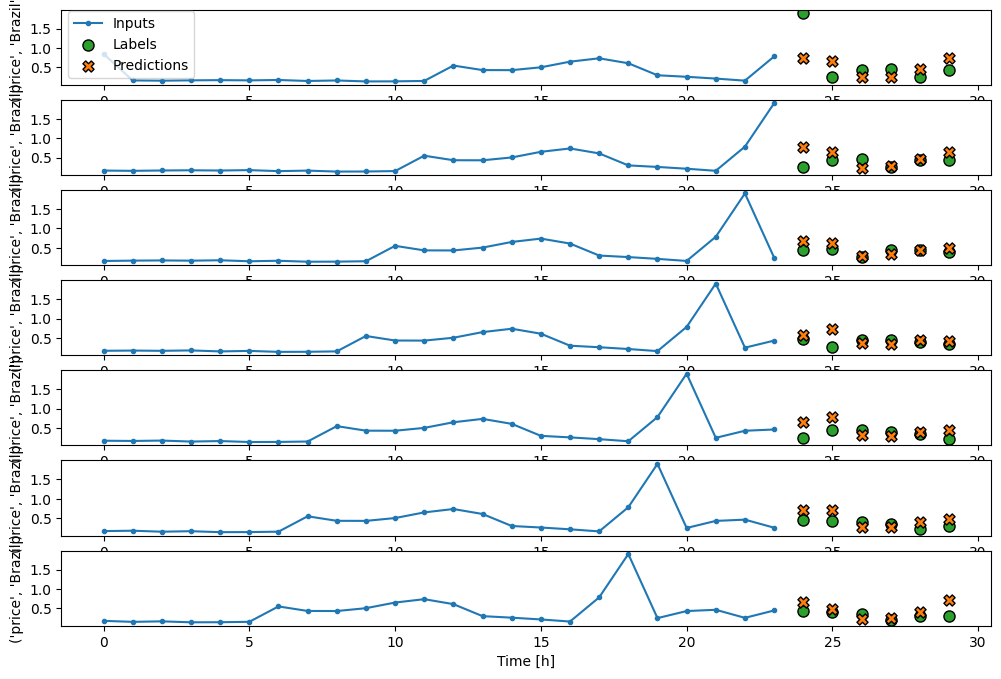

('price', 'France')


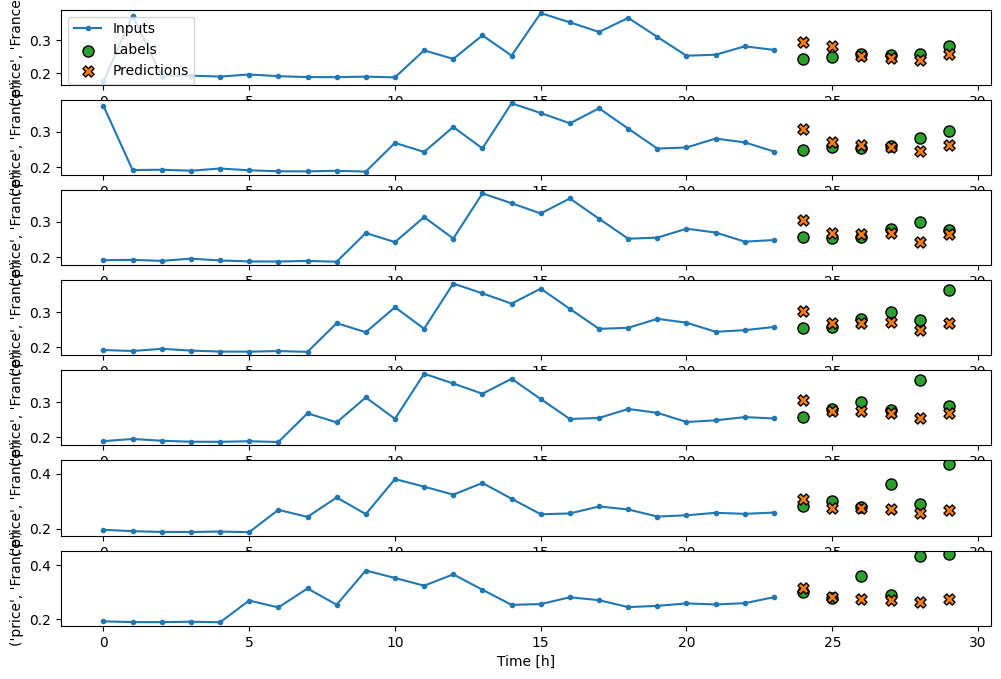

('price', 'Germany')


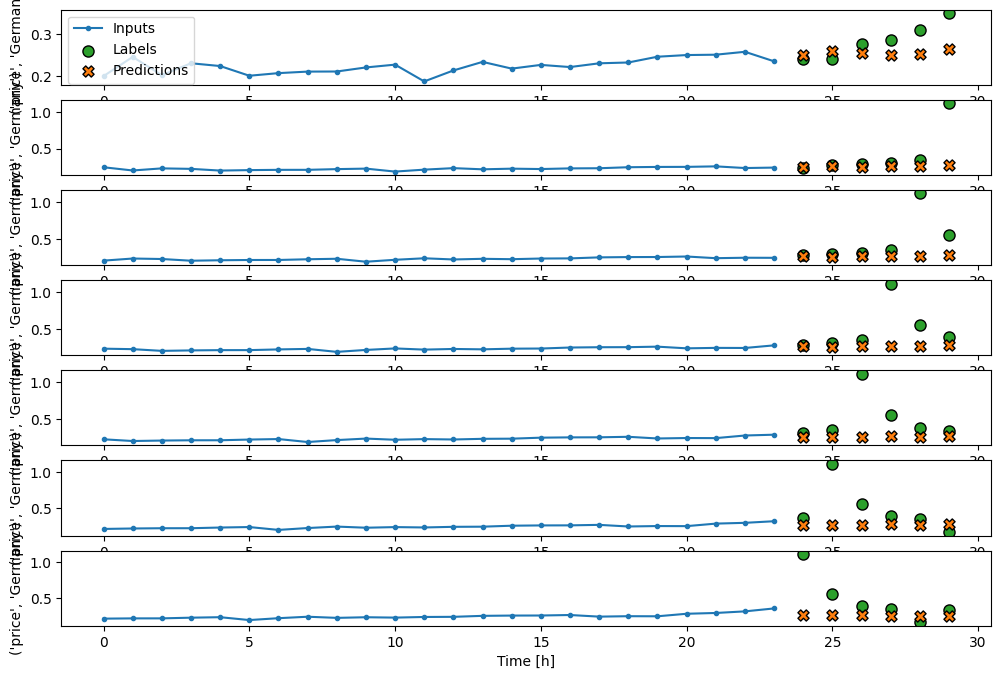

('price', 'Global')


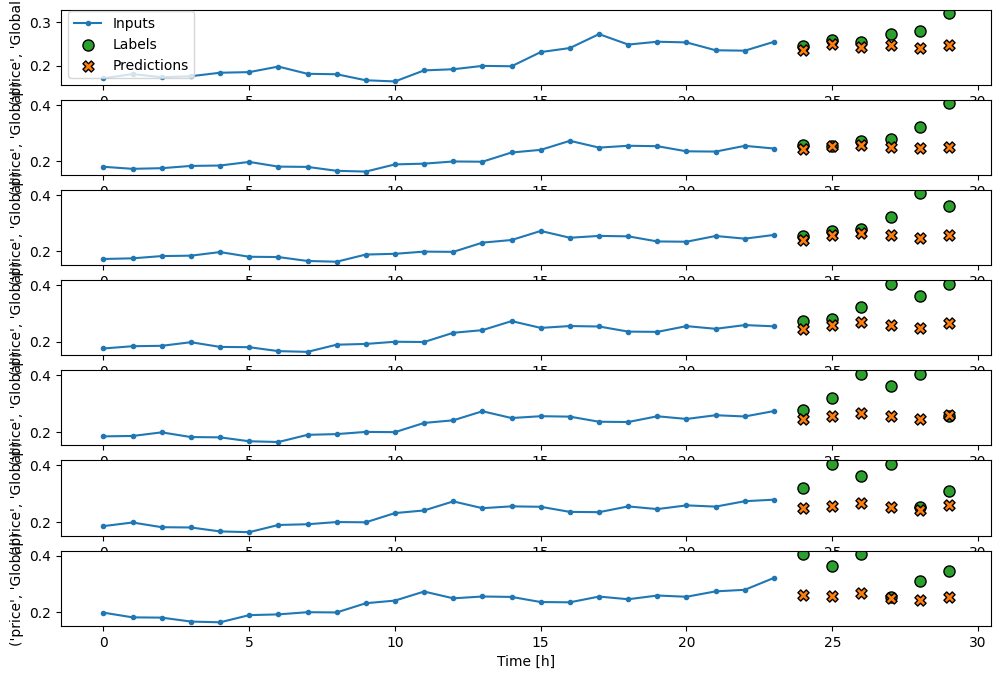

('price', 'Hungary')


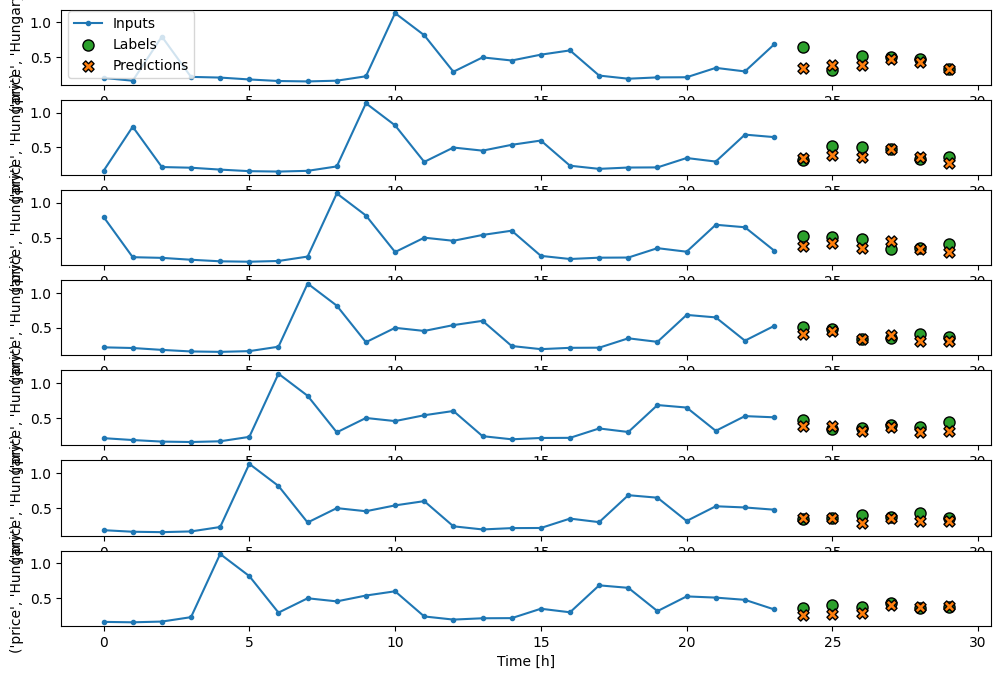

('price', 'Ukraine')


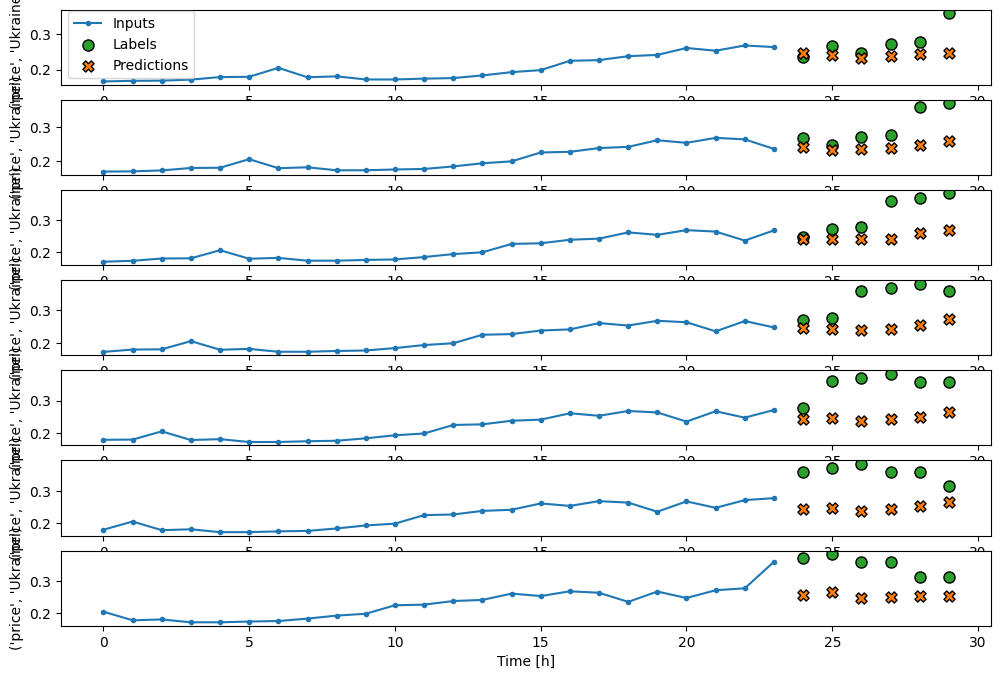

In [35]:
val_performance = {}
performance = {}

w.test

# val_performance['1'] = m.evaluate(w.val)
for i in range(6):

    label = label_columns[i]
    print(label)
    # performance['1'] = m.evaluate(w.test)
    w.plot(m, plot_col=label, max_subplots=7)


In [36]:
inputs, labels, predictions, weights = [], [], [], []
for x, y in w.test.take(1):
    inputs.append(x)
    labels.append(y)
    predictions.append(m(x))
    weights.append(m.attention_layer(x, return_weights=True)[1])
    
inputs = tf.concat(inputs, axis=0)
labels = tf.concat(labels, axis=0)
weights = tf.concat(weights, axis=0)
weights = tf.reduce_mean(weights, axis=0)
predictions = tf.concat(predictions, axis=0)

In [37]:
np.save(example_data_directory / "inputs", inputs.numpy())
np.save(example_data_directory / "labels", labels.numpy())
np.save(example_data_directory / "weights", weights.numpy())
np.save(example_data_directory / "predictions", predictions.numpy())


In [38]:
inputs = tf.convert_to_tensor(np.load(example_data_directory / "inputs.npy"))
labels = tf.convert_to_tensor(np.load(example_data_directory / "labels.npy"))
weights = tf.convert_to_tensor(np.load(example_data_directory / "weights.npy"))
predictions = tf.convert_to_tensor(np.load(example_data_directory / "predictions.npy"))

In [39]:
print(inputs.shape, labels.shape)

(7, 24, 75) (7, 6, 6)


In [40]:
for weight, column in zip(weights[0], w.train_df.columns):
    print(weight.numpy(), column)

0.5801161 ('price_trend', 'Brazil')
0.8202266 ('price_seasonal', 'Brazil')
0.98460525 ('price_residual', 'Brazil')
0.249866 ('price_trend', 'France')
0.83551246 ('price_seasonal', 'France')
0.7514033 ('price_residual', 'France')
0.4166479 ('price_trend', 'Germany')
0.9166562 ('price_seasonal', 'Germany')
0.70159775 ('price_residual', 'Germany')
0.9999929 ('price_trend', 'Global')
0.9166688 ('price_seasonal', 'Global')
0.7500102 ('price_residual', 'Global')
0.42150906 ('price_trend', 'Hungary')
0.918214 ('price_seasonal', 'Hungary')
0.5833333 ('price_residual', 'Hungary')
0.9170911 ('price_trend', 'Ukraine')
0.5833352 ('price_seasonal', 'Ukraine')
0.8063978 ('price_residual', 'Ukraine')
0.083434686 ('AVG_TAVG', 'Brazil')
0.25745785 ('AVG_TAVG', 'France')
0.08384515 ('AVG_TAVG', 'Germany')
0.07549052 ('AVG_TAVG', 'Hungary')
0.51967657 ('AVG_TAVG', 'Ukraine')
0.5228669 ('Corn Price Futures', 'Global')
0.833527 ('MAX_TMAX', 'Brazil')
0.74998397 ('MAX_TMAX', 'France')
0.58333045 ('MAX_TMAX'